<a href="https://colab.research.google.com/github/dashatrue/g_colab/blob/main/MO_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
url = '/content/drive/MyDrive/Colab Notebooks/Reddit_Combi.csv'
data = pd.read_csv(url, sep=";", quotechar='"', skipinitialspace=True, on_bad_lines='skip')
data = data.drop(columns=['Unnamed: 4'])
data.shape

(3123, 4)

In [ ]:
print(data.isna().sum())

title          0
body          10
Body_Title     0
label          0
dtype: int64


In [ ]:
data.dropna(inplace=True)

In [ ]:
#data['label'] = data['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [ ]:
data.head()

,title,body,Body_Title,label
0,Envy to other is swallowing me,"Im from developingcountry, Indonesia , and for...",Envy to other is swallowing me Im from develop...,1
1,Nothin outta the ordinary. Paradise. Job stres...,Um hello ....well many can relate im sure. Aft...,Nothin outta the ordinary. Paradise. Job stres...,1
2,Almost 49 and the chasm of emptiness has never...,I’ve been diagnosed severe bi polar where you ...,Almost 49 and the chasm of emptiness has never...,1
3,I’m happy again,"After my closest friend left me in April, I ha...",I’m happy again After my closest friend left m...,0
4,Is it possible to recover from such a traumati...,"I am only 15, and yet I feel my life is alread...",Is it possible to recover from such a traumati...,1


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

data = standardize_text(data, "body")

In [ ]:
#Токенизация
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

data["tokens"] = data["body"].apply(tokenizer.tokenize)
data.head()

,title,body,Body_Title,label,tokens
0,Envy to other is swallowing me,"im from developingcountry, indonesia , and for...",Envy to other is swallowing me Im from develop...,1,"[im, from, developingcountry, indonesia, and, ..."
1,Nothin outta the ordinary. Paradise. Job stres...,um hello ....well many can relate im sure. aft...,Nothin outta the ordinary. Paradise. Job stres...,1,"[um, hello, well, many, can, relate, im, sure,..."
2,Almost 49 and the chasm of emptiness has never...,i’ve been diagnosed severe bi polar where you ...,Almost 49 and the chasm of emptiness has never...,1,"[i, ve, been, diagnosed, severe, bi, polar, wh..."
3,I’m happy again,"after my closest friend left me in april, i ha...",I’m happy again After my closest friend left m...,0,"[after, my, closest, friend, left, me, in, apr..."
4,Is it possible to recover from such a traumati...,"i am only 15, and yet i feel my life is alread...",Is it possible to recover from such a traumati...,1,"[i, am, only, 15, and, yet, i, feel, my, life,..."


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
max_words = len(VOCAB)
max_len = 300
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

523365 words total, with a vocabulary size of 14121
Max sentence length is 5927


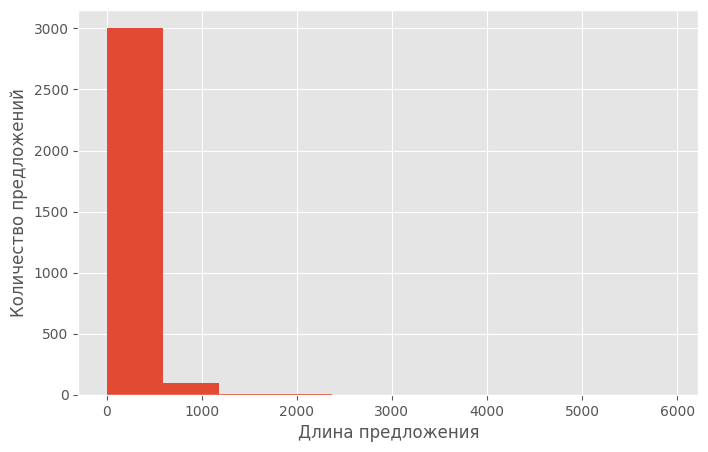

In [ ]:
fig = plt.figure(figsize=(8, 5))
plt.xlabel('Длина предложения')
plt.ylabel('Количество предложений')
plt.hist(sentence_lengths)
plt.show()

In [ ]:
#МЕШОК СЛОВ
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = data["body"].tolist()
list_labels = data["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

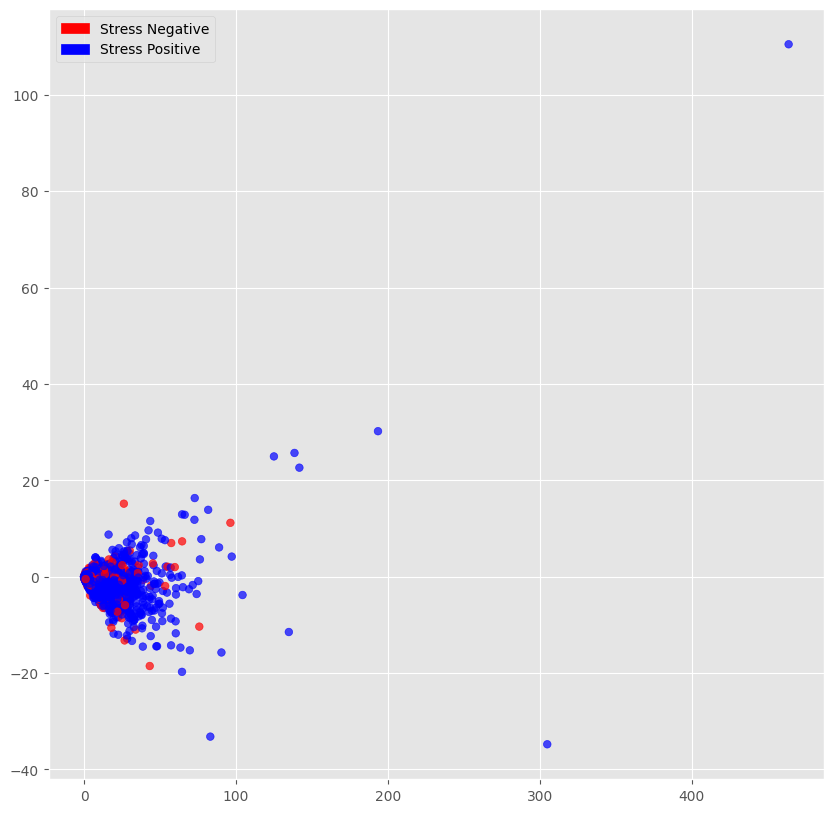

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches

lsa = TruncatedSVD(n_components=2, random_state=42)
X_train_lsa = lsa.fit_transform(X_train_counts)

# Цветовая карта: 0 - Stress Negative, 1 - Stress Positive
label_color_map = {0: 'red', 1: 'blue'}
colors = [label_color_map[label] for label in y_train]

plt.figure(figsize=(10, 10))
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=colors, alpha=0.7, s=30)

patches = [
    mpatches.Patch(color='red', label='Stress Negative'),
    mpatches.Patch(color='blue', label='Stress Positive')
]
plt.legend(handles=patches)
plt.grid(True)
plt.show()

In [ ]:
#Классификация: логистическая регрессия
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
#Метрики
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.912, precision = 0.918, recall = 0.912, f1 = 0.914


In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

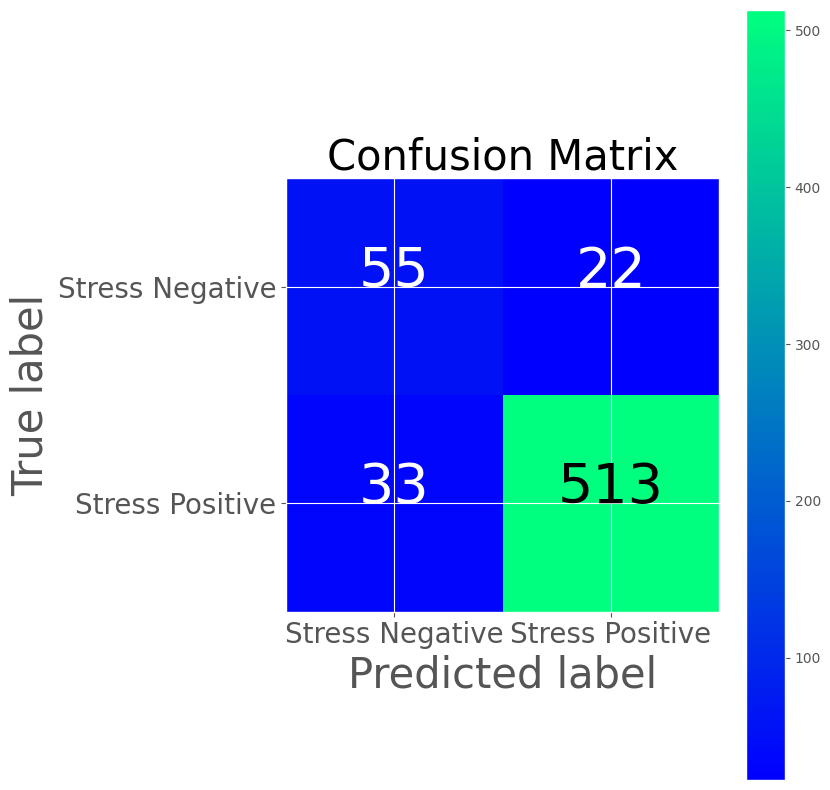

[[ 55  22]
 [ 33 513]]


In [ ]:
labels = [0, 1]
cm = confusion_matrix(y_test, y_predicted_counts, labels=labels)

fig = plt.figure(figsize=(8, 8))

plot = plot_confusion_matrix(cm, classes=['Stress Negative', 'Stress Positive'], normalize=False, title='Confusion Matrix')
plt.show()
print(cm)

In [ ]:
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([ 298, 2192]))


In [ ]:
#Важность
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)
print(importance)

{0: {'tops': [(1.0779820716205701, 'leave'), (1.0825986035946558, 'university'), (1.1210787044819641, 'end'), (1.1442447987431137, 'fight'), (1.1846031297421666, 'sad'), (1.2401927480985782, 'depressed'), (1.2842256345059146, 'fuck'), (1.3184398837984566, 'stress'), (1.3614566935202537, 'depression'), (1.426169740253893, 'stressed')], 'bottom': [(-1.3651095507927364, 'free'), (-1.4128358039869968, 'jerked'), (-1.5572921117694773, 'folks'), (-1.5594434313705459, 'finally'), (-1.5897909642921317, 'excited'), (-1.6652551760766483, 'believing'), (-1.7021323228313008, 'love'), (-1.7264320635320631, 'huhuhu'), (-2.2044488563650315, 'happy'), (-2.9116821218091955, 'amright')]}}


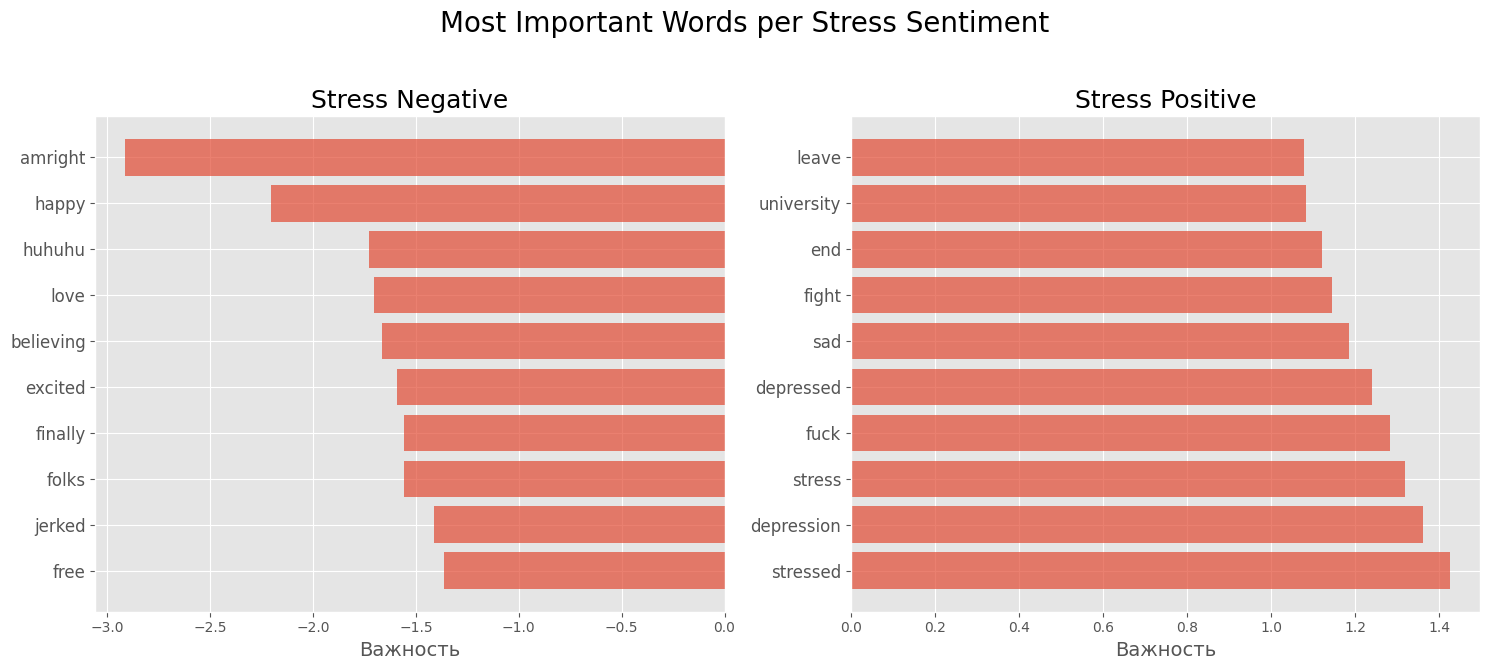

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}

    coef = model.coef_[0]  # Только один набор коэффициентов для бинарной классификации

    word_importances = [(el, index_to_word[i]) for i, el in enumerate(coef)]
    sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)

    tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
    bottom = sorted(sorted_coeff[-n:])

    return {
        1: {'tops': tops},     # Положительные (наиболее характерные для класса 1)
        0: {'tops': bottom}    # Отрицательные (наиболее характерные для класса 0)
    }

# Получаем данные для двух классов
importance = get_most_important_features(count_vectorizer, clf, 10)

# Убедимся, что индексы классов корректны
if 0 in importance and 1 in importance:
    negative_scores = [a[0] for a in importance[0]['tops']]
    negative_words = [a[1] for a in importance[0]['tops']]

    positive_scores = [a[0] for a in importance[1]['tops']]
    positive_words = [a[1] for a in importance[1]['tops']]
else:
    print("Ошибка: классы не найдены в importance.")

# Структура данных для визуализации
class_scores_words = [
    (negative_scores, negative_words),
    (positive_scores, positive_words)
]

class_names = ['Stress Negative', 'Stress Positive']

# Визуализация
def plot_important_words_2class(class_scores_words, class_names, name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))  # 2 графика вместо 3
    fig.suptitle(name, fontsize=20)

    for i, (scores, words) in enumerate(class_scores_words):
        y_pos = np.arange(len(words))
        pairs = sorted(zip(words, scores), key=lambda x: x[1])
        sorted_words = [w for w, _ in pairs]
        sorted_scores = [s for _, s in pairs]

        axs[i].barh(y_pos, sorted_scores, align='center', alpha=0.7)
        axs[i].set_title(class_names[i], fontsize=18)
        axs[i].set_yticks(y_pos)
        axs[i].set_yticklabels(sorted_words, fontsize=12)
        axs[i].invert_yaxis()
        axs[i].set_xlabel("Важность", fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Отображаем важные слова для двух классов
plot_important_words_2class(class_scores_words, class_names, "Most Important Words per Stress Sentiment")

In [ ]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    from sklearn.decomposition import TruncatedSVD
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)

    unique_labels = sorted(set(test_labels))
    color_mapper = {label: idx for idx, label in enumerate(unique_labels)}
    color_column = [color_mapper[label] for label in test_labels]

    # Автоматическое построение палитры
    cmap = matplotlib.cm.get_cmap('Set1', len(unique_labels))

    if plot:
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=.8,
                    c=color_column, cmap=cmap)

        # Динамическая легенда
        handles = [mpatches.Patch(color=cmap(i), label=str(label)) for i, label in enumerate(unique_labels)]
        plt.legend(handles=handles, prop={'size': 15})
        plt.title("LSA Projection (2D)", fontsize=20)


In [ ]:
#TF-IDF
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

<ipython-input-23-279e96addc4b>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Set1', len(unique_labels))


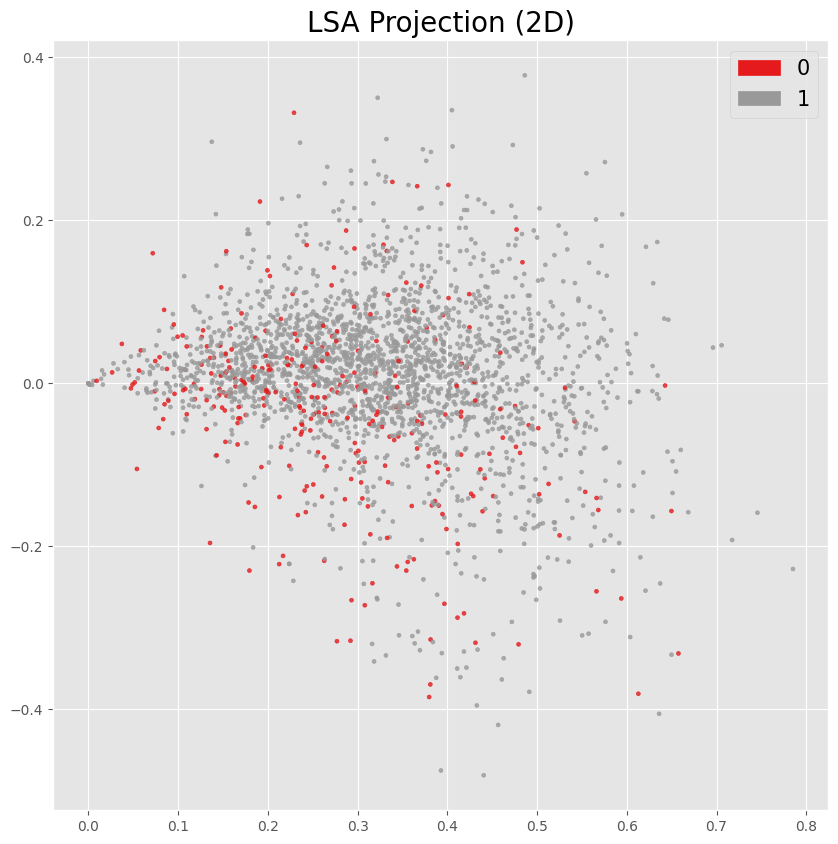

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.926, precision = 0.925, recall = 0.926, f1 = 0.925


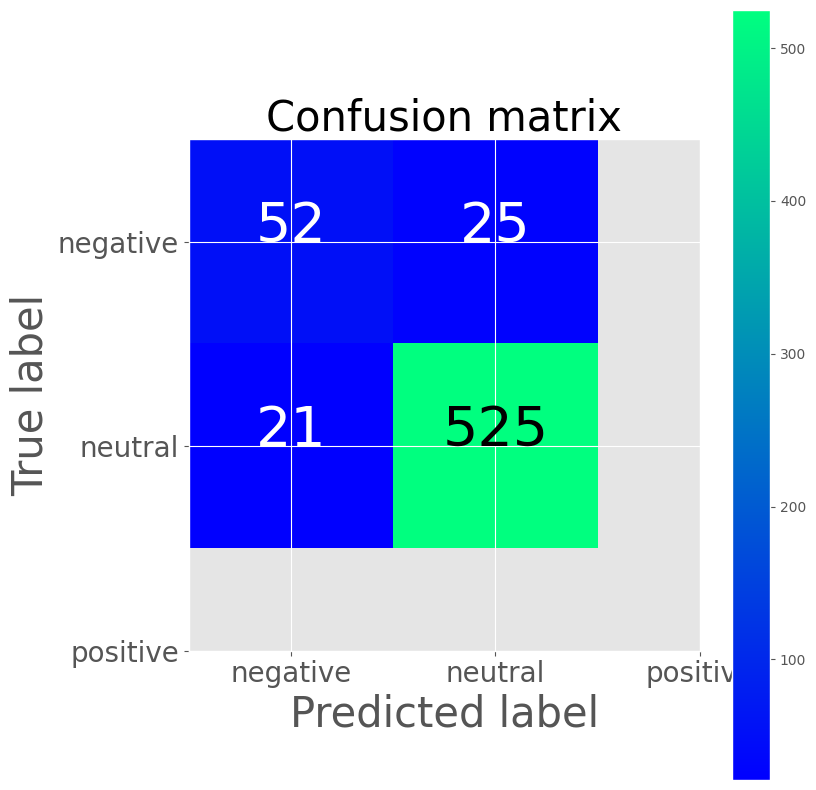

TFIDF confusion matrix
[[ 52  25]
 [ 21 525]]
BoW confusion matrix
[[ 55  22]
 [ 33 513]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(8, 8))
plot = plot_confusion_matrix(cm2, classes=['negative','neutral','positive'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [ ]:
#pip install gensim

In [ ]:
#pip install --upgrade --force-reinstall numpy gensim

In [ ]:
#Word2Vec
import gensim
import gensim.downloader as api

word2vec = api.load("word2vec-google-news-300")

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, data)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=40)

<ipython-input-23-279e96addc4b>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Set1', len(unique_labels))


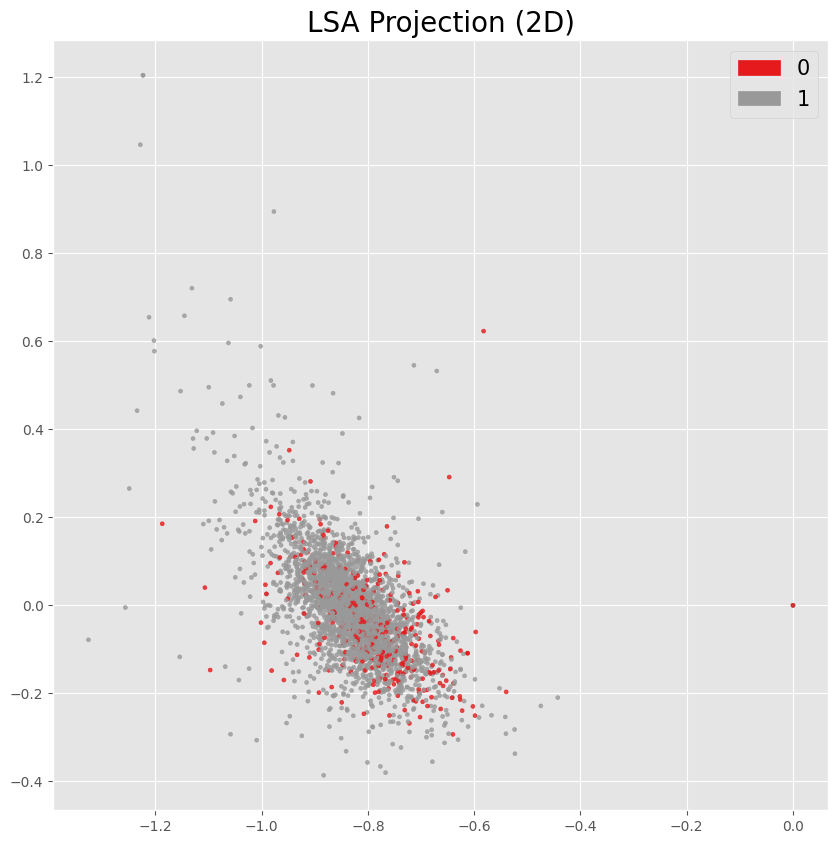

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(embeddings, list_labels)
plt.show()

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.872, precision = 0.910, recall = 0.872, f1 = 0.884


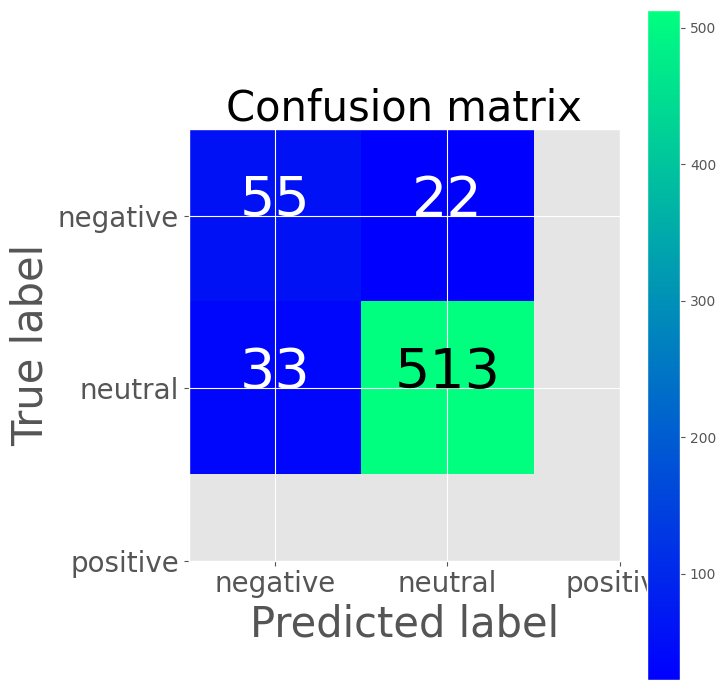

Word2Vec confusion matrix
[[ 62  15]
 [ 65 481]]
TFIDF confusion matrix
[[ 52  25]
 [ 21 525]]
BoW confusion matrix
[[ 55  22]
 [ 33 513]]


In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=['negative','neutral','positive'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [ ]:
#RNN / CNN
# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential

# Deep Learning Model - Keras - CNN
from keras.layers import Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D, \
    GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.layers import MaxPooling3D, GlobalMaxPooling3D, GlobalAveragePooling3D

# Deep Learning Model - Keras - RNN
from keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential

def get_rnn_model(num_class=2):
    model = Sequential()

    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(LSTM(256))

    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))

    model.summary()

    return model


def get_cnn_model(num_class=2):
    model = Sequential()

    model.add(Embedding(max_words, 100, input_length=max_len))

    model.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())


    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(2048, activation='relu'))

    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))

    model.summary()
    return model

In [ ]:
num_class = 2
model1 = get_rnn_model(num_class=num_class)
model1.build(input_shape=(None, max_len))
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     1,412,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,912,837 (7.30 MB)

 Trainable params: 1,911,301 (7.29 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import time

# Подготовка входных данных
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)

# Подготовка меток
Y_train = np.array(y_train)  # метки в одномерном виде для бинарной классификации

# Определение параметров
loss = 'binary_crossentropy'
metrics = ['accuracy']
learning_rate = 0.001
optimizer = Adam(learning_rate)

# Компиляция модели
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Обучение модели
print("Starting...\n")
start_time = time.time()

history1 = model1.fit(
    X_train_seq,
    Y_train,
    batch_size=128,
    epochs=100,
    verbose=1,
    validation_split=0.2
)

# Время обучения
elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print("\nElapsed Time: " + elapsed_time)


Starting...

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8832 - loss: 0.3928 - val_accuracy: 0.8574 - val_loss: 0.4146
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8642 - loss: 0.4300 - val_accuracy: 0.8574 - val_loss: 0.4118
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8641 - loss: 0.4304 - val_accuracy: 0.8574 - val_loss: 0.4160
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8795 - loss: 0.3942 - val_accuracy: 0.8574 - val_loss: 0.4229
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8796 - loss: 0.3878 - val_accuracy: 0.8574 - val_loss: 0.4187
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8813 - loss: 0.3750 - val_accuracy: 0.8574 - val_loss: 0.4072
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8807 - loss: 0.3843 - val_accuracy: 0.8574 - val_loss: 0.4051
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8842 - loss: 0.3651 - val

In [ ]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    # Печать значений точности и потерь
    print("Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss")
    for epoch in range(len(history.history['accuracy'])):
        print(f"{epoch+1}    | {history.history['accuracy'][epoch]:.4f}       | {history.history['val_accuracy'][epoch]:.4f}       | {history.history['loss'][epoch]:.4f}        | {history.history['val_loss'][epoch]:.4f}")

    plt.figure(figsize=(20, 5))

    # Точность
    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2)) - ylim_pad[0]
    max_y = max(max(y1), max(y2)) + ylim_pad[0]

    plt.subplot(121)
    plt.plot(y1, label='Training')
    plt.plot(y2, label='Validation')

    plt.title('Model Accuracy\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    # Потери
    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2)) - ylim_pad[1]
    max_y = max(max(y1), max(y2)) + ylim_pad[1]

    plt.subplot(122)
    plt.plot(y1, label='Training')
    plt.plot(y2, label='Validation')

    plt.title('Model Loss\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    if figure_directory:
        plt.savefig(figure_directory + "/history")

    plt.show()

Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss
1    | 0.8730       | 0.8574       | 0.4163        | 0.4146
2    | 0.8755       | 0.8574       | 0.4105        | 0.4118
3    | 0.8780       | 0.8574       | 0.3940        | 0.4160
4    | 0.8780       | 0.8574       | 0.3956        | 0.4229
5    | 0.8800       | 0.8574       | 0.3861        | 0.4187
6    | 0.8820       | 0.8574       | 0.3757        | 0.4072
7    | 0.8815       | 0.8574       | 0.3793        | 0.4051
8    | 0.8820       | 0.8574       | 0.3583        | 0.3981
9    | 0.8926       | 0.8594       | 0.2994        | 0.4008
10    | 0.9227       | 0.8635       | 0.2129        | 0.4161
11    | 0.9463       | 0.8353       | 0.1507        | 0.4087
12    | 0.9629       | 0.8635       | 0.1059        | 0.4839
13    | 0.9804       | 0.8695       | 0.0736        | 0.4800
14    | 0.9905       | 0.8715       | 0.0392        | 0.5784
15    | 0.9935       | 0.8675       | 0.0258        | 0.6236
16    | 0.99

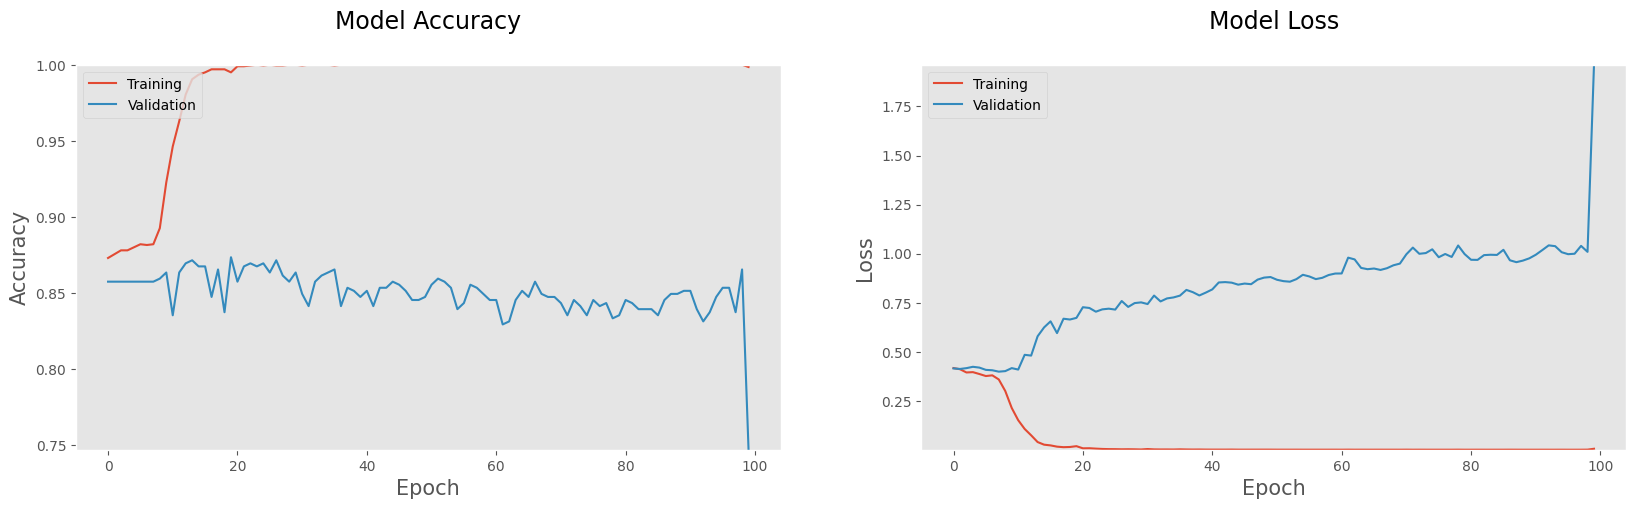

In [ ]:
plot_performance(history=history1)

In [ ]:
num_class = 2
model2 = get_cnn_model(num_class=num_class)
model2.build(input_shape=(None, max_len))
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 300, 100)       │     1,412,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 298, 1024)      │       308,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 1024)           │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,833,861 (14.63 MB)

 Trainable params: 3,827,717 (14.60 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [ ]:
print("Starting...\n")

start_time = time.time()

print("\n\nCompliling Model ...\n")
learning_rate = 0.001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

verbose = 1
epochs = 100
batch_size = 128
validation_split = 0.2

print("Trainning Model ...\n")

history2 = model2.fit(
    X_train_seq,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=validation_split,
    )

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning")

Starting...



Compliling Model ...

Trainning Model ...

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 377ms/step - accuracy: 0.5325 - loss: 0.9905 - val_accuracy: 0.8574 - val_loss: 0.4698
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6650 - loss: 0.7413 - val_accuracy: 0.8574 - val_loss: 0.4148
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7274 - loss: 0.5830 - val_accuracy: 0.8574 - val_loss: 0.4068
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7823 - loss: 0.5170 - val_accuracy: 0.8574 - val_loss: 0.4128
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8401 - loss: 0.4109 - val_accuracy: 0.8574 - val_loss: 0.4182
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8228 - loss: 0.4225 - val_accuracy: 0.8574 - val_loss: 0.4234
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8558 - loss: 0.3504 - val_accuracy: 0.8574 - val_loss: 0.4273
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37

Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss
1    | 0.5427       | 0.8574       | 0.9815        | 0.4698
2    | 0.6817       | 0.8574       | 0.7181        | 0.4148
3    | 0.7349       | 0.8574       | 0.5725        | 0.4068
4    | 0.7882       | 0.8574       | 0.5178        | 0.4128
5    | 0.8333       | 0.8574       | 0.4221        | 0.4182
6    | 0.8288       | 0.8574       | 0.4081        | 0.4234
7    | 0.8559       | 0.8574       | 0.3439        | 0.4273
8    | 0.8760       | 0.8574       | 0.2978        | 0.4279
9    | 0.9101       | 0.8574       | 0.2332        | 0.4371
10    | 0.9388       | 0.8574       | 0.1772        | 0.4508
11    | 0.9307       | 0.8574       | 0.1720        | 0.4657
12    | 0.9508       | 0.8574       | 0.1371        | 0.4909
13    | 0.9558       | 0.8574       | 0.1195        | 0.5134
14    | 0.9719       | 0.8574       | 0.0816        | 0.5370
15    | 0.9739       | 0.8574       | 0.0824        | 0.5507
16    | 0.98

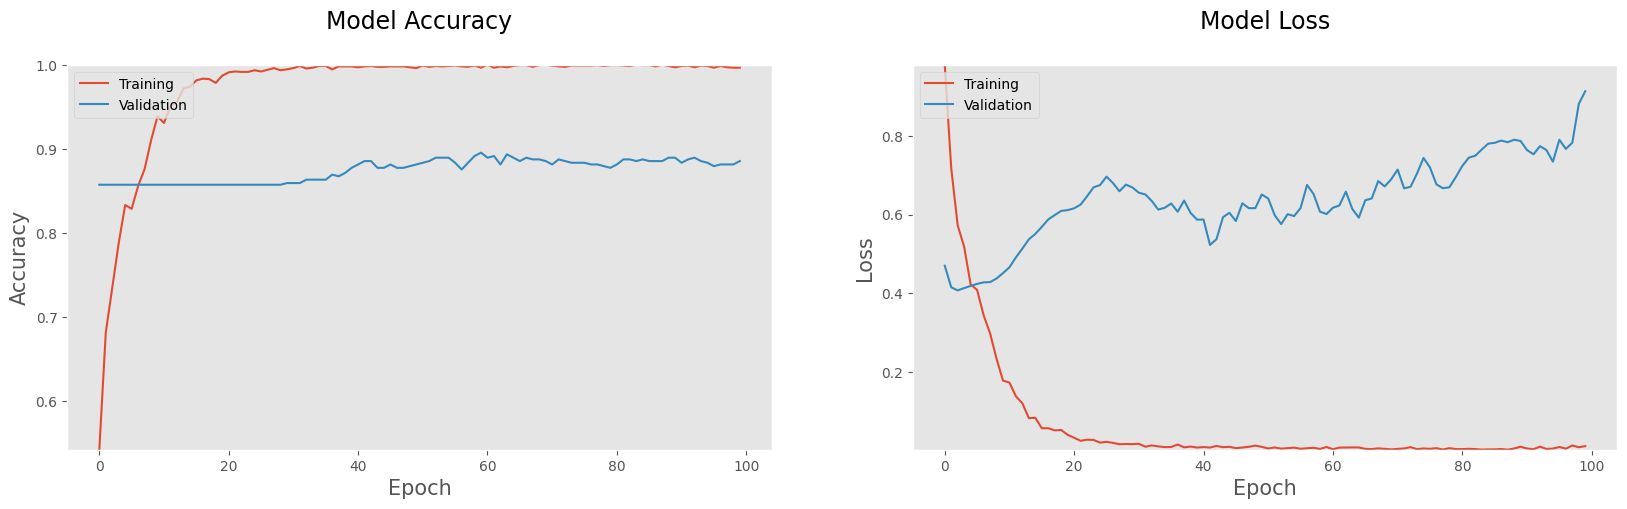

In [ ]:
plot_performance(history=history2)